# Simulating Quantum Circuits & Noise with Aer (Density-Matrix)

**Goal.** Build an intuition-first, reproducible sandbox for **noisy quantum circuits** using Qiskit Aer’s `density_matrix` method.  
We prepare simple states (|+⟩, Bell) and pass them through **physically motivated noise channels** (depolarizing, \\(T_1/T_2\\) relaxation, optional readout error), then quantify the impact via **purity**, **Bloch vectors**, and **fidelity**.

---

## Why density matrices?

Real devices interact with their environment, so pure states \\(|\psi\rangle\\) become **mixed**. The **density matrix** \\(\rho\\) captures both:

- **Noiseless (unitary) evolution:** \\( \rho' = U\rho U^\dagger \\).
- **Noisy (open-system) evolution (Kraus):**  
  \\( \rho' = \sum_k E_k\,\rho\,E_k^\dagger,\quad \sum_k E_k^\dagger E_k = I \\) (CPTP map).

Using `method="density_matrix"` simulates \\(\rho\\) directly, letting us apply realistic channels **gate-by-gate**.

---

## Noise channels modeled

### 1) Depolarizing (basis-agnostic mixing)
For 1-qubit states:
\\[
\mathcal{E}_{\text{dep}}(\rho) = (1-p)\rho + \frac{p}{3}\big(X\rho X + Y\rho Y + Z\rho Z\big).
\\]
**Effect:** isotropic shrink of the Bloch vector → information loss independent of basis.

### 2) Thermal relaxation (\\(T_1, T_2\\))
Models energy relaxation and dephasing over a **gate time** \\(\tau\\):
- \\(T_1\\): population decay \\(|1\rangle \to |0\rangle\\).
- \\(T_2\\): coherence decay with \\( 1/T_2 = 1/(2T_1) + 1/T_\phi \\) (splits relaxation vs. pure dephasing).

**Effect:** off-diagonals decay; excited-state population relaxes toward ground. Longer gates ⇒ more decay per gate.

### 3) Readout error (classical confusion)
A classical bit-flip model with probability \\(p_{\text{meas}}\\) that **skews counts** post-measurement (does **not** change \\(\rho\\) before measurement).

---

## What we simulate

1. **Single-qubit \\(|+\rangle\\)**  
   Circuit: \\(H|0\rangle\\).  
   - *Noiseless:* purity \\(=1\\), Bloch \\(\approx (1,0,0)\\).  
   - *Noisy:* purity \\(<1\\), Bloch length shrinks, fidelity to \\(|+\rangle\\) drops.

2. **Two-qubit Bell state \\(|\Phi^+\rangle\\)**  
   Circuit: \\(H\\) on qubit 0, then \\(CX(0\!\to\!1)\\).  
   - *Noiseless:* global purity \(=1\); each **reduced** qubit \\(\approx I/2\\) (signature of entanglement).  
   - *Noisy:* global purity and Bell fidelity drop, especially sensitive to **2-qubit gate** noise and longer **CX gate time**.

3. **Optional readout error demo**  
   Prepare \\(|+\rangle\\), measure in \\(Z\\). Ideal counts are ~50/50; readout error introduces a small, controlled skew.

---

## Metrics we print

- **Purity** \\(P=\mathrm{Tr}(\rho^2)\\): \\(=1\\) (pure), \\(<1\\) (mixed).  
- **Bloch vector** \\(\vec r=(\langle X\rangle,\langle Y\rangle,\langle Z\rangle)\\) (1-qubit diagnostics).  
- **State fidelity** \\(F(\rho,\sigma)\\) (via `state_fidelity`): similarity to an ideal target (e.g., \\(|+\rangle\\), Bell).

---

## How the simulator attaches noise (important!)

We **transpile** circuits to a backend basis (typically `["id","rz","sx","x","cx"]`). Noise must be assigned to **these basis ops**.  
Even if you write `h`, it decomposes into `rz/sx/x`; attaching noise to `["id","rz","sx","x"]` is robust.

We **compose** the 1-qubit channels (thermal ∘ depolarizing) into a single error and attach it **once** per instruction, avoiding “already exists, composing again” warnings and making the model explicit.

---

## Physics knobs to tune

- **Error probabilities:** \\(p_1\\) (1-q depolarizing), \\(p_2\\) (2-q depolarizing).  
- **Timescales:** \\(T_1, T_2\\) (device coherence), **gate times** \\(\tau_{1q}, \tau_{2q}\\) (exposure to relaxation).  
- **Readout flip prob:** \\(p_{\text{meas}}\\).

**Expected trends:**
- ↓\\(T_2\\) or ↑\\(\tau\\) ⇒ faster coherence loss (Bloch \\(x,y\\) shrink).  
- ↓\\(T_1\\) ⇒ relaxation toward \(|0\rangle\), reducing excited-state population and coherences.  
- ↑\\(p_2\\) or ↑\\(\tau_{2q}\\) ⇒ Bell fidelity degrades notably (entangling gates are fragile).  
- ↑\\(p_{\text{meas}}\\) ⇒ counts skew more; underlying density-matrix fidelities unchanged.

---

## Scope & limitations

- **Exactness vs size:** density-matrix memory scales as \\(4^n\\). Excellent for few-qubit, high-fidelity studies; not for large \\(n\\).  
- **Model granularity:** channels are **gate-localized** approximations. For pulse-level/continuous-time dynamics, consider pulse simulation or full Lindblad solvers.  
- **Parameter realism:** set \\(T_1/T_2\\), gate times, and \\(p_1/p_2\\) to match specific backends (or import calibration data).

---

## Extensions (for the chapter)

- Swap depolarizing for **Pauli channels** or **general Kraus** maps.  
- Separate \\(T_\phi\\) from \\(T_2\\) to isolate **pure dephasing**.  
- Add **leakage** or **crosstalk** channels.  
- Use real hardware **calibration snapshots** to build data-driven noise models.  
- Compare density-matrix results to **stabilizer** (fast, Clifford) or **tensor-network** simulators on larger circuits.  
- Add a small **parameter sweep** (e.g., CX gate time) and plot fidelity vs parameter for a figure-ready result.

---

**Takeaway.** This notebook offers a compact bridge from **physics parameters** \\((T_1,T_2,\text{gate times},p)\\) to **observable effects** (purity loss, Bloch shrinkage, fidelity drop, skewed counts), building intuition for how circuit depth and gate quality shape algorithmic performance on NISQ hardware.


In [21]:
# ---------------------------------------------------------------
# Simulating quantum circuits with Aer density-matrix + clean noise model
# ---------------------------------------------------------------
# Optional install (uncomment if needed):
# !pip install "qiskit-aer>=0.14" "qiskit-terra>=0.25" numpy

from __future__ import annotations
import numpy as np
from math import pi
from copy import deepcopy

# Core Qiskit: circuits and transpiler
from qiskit import QuantumCircuit, transpile

# Quantum information utilities for analysis
from qiskit.quantum_info import DensityMatrix, partial_trace, state_fidelity, Pauli

# Aer simulator backend
from qiskit_aer import AerSimulator

# Noise objects and prebuilt channels
from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error,
    thermal_relaxation_error,
    ReadoutError,
)

# -----------------------------
# Helpers
# -----------------------------
def purity(rho: np.ndarray) -> float:
    """Return state purity Tr(rho^2). =1 for pure states; <1 for mixed."""
    return float(np.real_if_close(np.trace(rho @ rho)))

def bloch_vector(rho: np.ndarray) -> np.ndarray:
    """Return (⟨X⟩, ⟨Y⟩, ⟨Z⟩) for a 1-qubit density matrix (diagnoses decoherence)."""
    return np.array([
        np.real_if_close(np.trace(rho @ Pauli("X").to_matrix())),
        np.real_if_close(np.trace(rho @ Pauli("Y").to_matrix())),
        np.real_if_close(np.trace(rho @ Pauli("Z").to_matrix())),
    ], dtype=float)

def run_and_get_dm(circ: QuantumCircuit, simulator: AerSimulator) -> np.ndarray:
    """
    Run `circ` on `simulator` and return the final density matrix as a NumPy array.
    - We call save_density_matrix() to record ρ at the end of the circuit.
    - We transpile so that noise attaches to basis gates actually executed.
    """
    c = circ.copy()                     # keep original circuit untouched
    c.save_density_matrix()             # tell Aer to save final density matrix
    tqc = transpile(c, simulator)       # map to backend basis ops (important for noise)
    result = simulator.run(tqc).result()
    dm = result.data(0)["density_matrix"]  # a qiskit.quantum_info.DensityMatrix
    return np.asarray(dm, dtype=complex)   # return as ndarray for easy math

# -----------------------------
# Simulators (noiseless & noisy)
# -----------------------------
# Noiseless density-matrix simulator: evolves ρ exactly (CPTP channels if present)
sim_dm_clean = AerSimulator(method="density_matrix")

# -----------------------------
# Noise model (clean composition → no warnings)
# -----------------------------
# Create a container for gate-specific noise channels
noise = NoiseModel()

# Use modern 1-qubit basis ops; H/U decompose into these under transpilation
oneq_ops = ["id", "rz", "sx", "x"]

# Physical parameters (tweak to explore regimes)
p1 = 0.01              # depolarizing probability per 1q gate (isotropic Pauli noise)
T1 = 50e-6             # energy relaxation time (seconds)
T2 = 40e-6             # dephasing time (seconds)
gate_time_1q = 35e-9   # duration of a 1q gate (seconds) → amount of relaxation applied

# Build individual 1q errors:
# - depolarizing mixes the Bloch vector isotropically
# - thermal_relaxation applies T1/T2 decay over the specified gate time
depol_1q = depolarizing_error(p1, 1)
therm_1q = thermal_relaxation_error(T1, T2, gate_time_1q)

# Combine both effects into a single channel for clarity (avoids duplicate-add warnings).
# Order is a modeling choice; therm.compose(depol) ≈ apply depolarizing then relaxation.
combined_1q = therm_1q.compose(depol_1q)

# Attach the combined 1q noise to every qubit for the given instructions
noise.add_all_qubit_quantum_error(combined_1q, oneq_ops)

# OPTIONAL: add CX noise (2-qubit)
add_cx_noise = True
if add_cx_noise:
    p2 = 0.02              # depolarizing prob per 2q gate (often larger than 1q)
    gate_time_2q = 250e-9  # CX duration (longer gate → more relaxation exposure)

    depol_2q = depolarizing_error(p2, 2)
    # Relaxation on both qubits during CX: tensor two single-qubit thermal channels
    therm_2q = thermal_relaxation_error(T1, T2, gate_time_2q).tensor(
        thermal_relaxation_error(T1, T2, gate_time_2q)
    )
    combined_2q = therm_2q.compose(depol_2q)

    # Attach to the CX instruction
    noise.add_all_qubit_quantum_error(combined_2q, ["cx"])

# Build the noisy density-matrix simulator with the noise model attached
sim_dm_noisy = AerSimulator(method="density_matrix", noise_model=noise)

# -----------------------------
# 1) Single-qubit: prepare |+> and compare
# -----------------------------
# Circuit: |0> --H--> |+>
qc_plus = QuantumCircuit(1, name="H_to_plus")
qc_plus.h(0)

# Noiseless result (reference)
rho_clean = run_and_get_dm(qc_plus, sim_dm_clean)
print("Noiseless |+> density matrix:\n", np.round(rho_clean, 3))
print("Purity (should be 1.0):", round(purity(rho_clean), 6))
print("Bloch (~[1,0,0]):", np.round(bloch_vector(rho_clean), 3))

# Noisy result (with depolarizing + relaxation)
rho_noisy = run_and_get_dm(qc_plus, sim_dm_noisy)
print("\nNoisy |+> density matrix:\n", np.round(rho_noisy, 3))
print("Purity (< 1.0):", round(purity(rho_noisy), 6))
print("Bloch (shrunk toward origin):", np.round(bloch_vector(rho_noisy), 3))

# Similarity to ideal |+> (state fidelity)
fid_plus = state_fidelity(DensityMatrix(rho_clean), DensityMatrix(rho_noisy))
print("Fidelity to ideal |+>:", round(fid_plus, 6))

# -----------------------------
# 2) Two-qubit Bell state: entanglement & reductions
# -----------------------------
# Prepare |Φ+> = (|00> + |11>)/√2 using H on qubit 0 followed by CX
bell = QuantumCircuit(2, name="bell")
bell.h(0)
bell.cx(0, 1)

# Noiseless Bell state (globally pure)
rho2_clean = run_and_get_dm(bell, sim_dm_clean)
print("\nNoiseless Bell ρ shape:", rho2_clean.shape)
print("Noiseless Bell purity:", round(purity(rho2_clean), 6))

# Reduced single-qubit state: trace out qubit 1 → maximally mixed I/2 (signature of entanglement)
rhoA = partial_trace(DensityMatrix(rho2_clean), [1]).data
print("Reduced ρ of qubit 0 (≈ I/2):\n", np.round(rhoA, 3))
print("Purity of reduced (~0.5):", round(purity(rhoA), 6))

# Noisy Bell: entanglement degrades due to 2q + relaxation noise
rho2_noisy = run_and_get_dm(bell, sim_dm_noisy)
print("\nNoisy Bell purity:", round(purity(rho2_noisy), 6))
fid_bell = state_fidelity(DensityMatrix(rho2_clean), DensityMatrix(rho2_noisy))
print("Fidelity to ideal Bell:", round(fid_bell, 6))

# -----------------------------
# 3) Optional readout error demo (counts skew)
# -----------------------------
# Readout error models classical confusion in measurement outcomes (no change to ρ pre-meas).
enable_readout_demo = True
if enable_readout_demo:
    p_meas = 0.02
    # Symmetric bit-flip matrix: [[P(0|0), P(1|0)], [P(0|1), P(1|1)]]
    ro = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

    # Make a safe copy of the current noise model and add readout confusion
    noise_with_ro = deepcopy(noise)                      # (NoiseModel has no .copy())
    noise_with_ro.add_all_qubit_readout_error(ro)

    # Simulator with identical state noise + readout error attached
    sim_dm_meas = AerSimulator(method="density_matrix", noise_model=noise_with_ro)

    # Prepare |+> and measure in Z: ideally 50/50, with readout error → slight skew
    meas = QuantumCircuit(1, 1)
    meas.h(0)
    meas.measure(0, 0)

    meas_t = transpile(meas, sim_dm_meas)
    res = sim_dm_meas.run(meas_t, shots=5000).result()
    print("\nCounts with readout error (~50/50 but slightly skewed):", res.get_counts())

# -----------------------------
# Notes / variations
# -----------------------------
# - Increase p1/p2 or reduce T1/T2 to see stronger decoherence / lower fidelities.
# - Remove CX noise by setting add_cx_noise = False (helps isolate 1q vs 2q effects).
# - Change gate_time_1q / gate_time_2q to reflect your target hardware.
# - Density-matrix scales as 4^n (memory); keep qubit counts modest for speed.


Noiseless |+> density matrix:
 [[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]
Purity (should be 1.0): 1.0
Bloch (~[1,0,0]): [1. 0. 0.]

Noisy |+> density matrix:
 [[0.501+0.j 0.484+0.j]
 [0.484-0.j 0.499+0.j]]
Purity (< 1.0): 0.969096
Bloch (shrunk toward origin): [ 0.969 -0.     0.001]
Fidelity to ideal |+>: 0.984301

Noiseless Bell ρ shape: (4, 4)
Noiseless Bell purity: 1.0
Reduced ρ of qubit 0 (≈ I/2):
 [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]
Purity of reduced (~0.5): 0.5

Noisy Bell purity: 0.924779
Fidelity to ideal Bell: 0.961291

Counts with readout error (~50/50 but slightly skewed): {'1': 2515, '0': 2485}


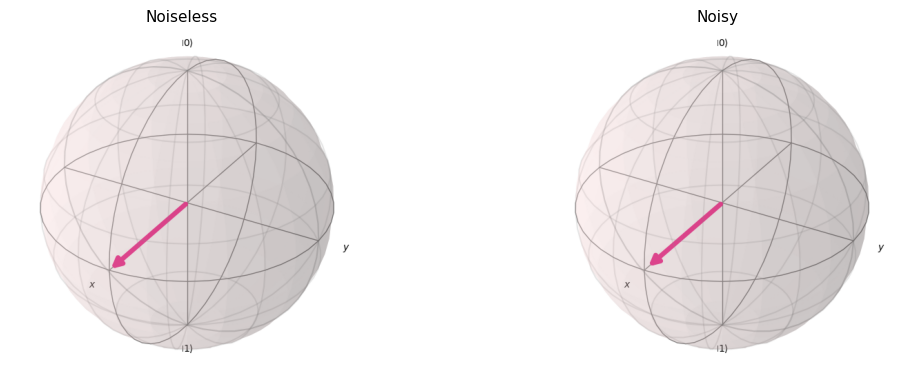

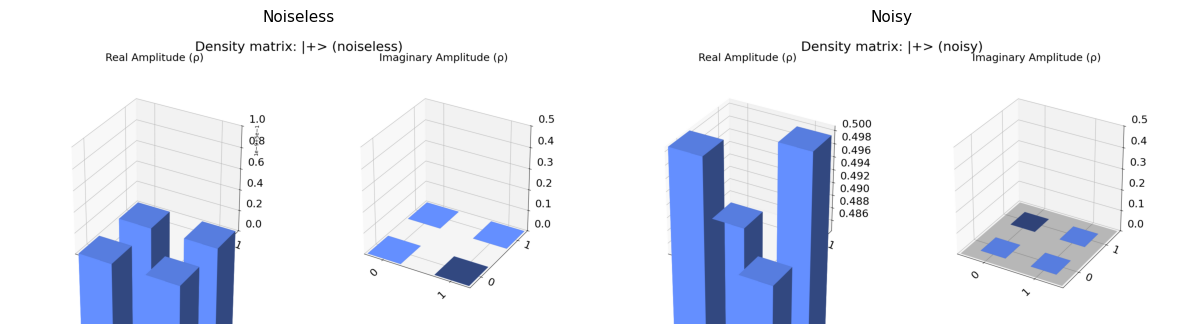

In [14]:
# Convert to qiskit DensityMatrix objects for the visualization helpers
dm_clean = DensityMatrix(rho_clean)
dm_noisy = DensityMatrix(rho_noisy)

# Bloch vectors
bv_clean = bloch_vector(rho_clean)
bv_noisy = bloch_vector(rho_noisy)

fig1 = plot_bloch_vector(bv_clean, title="Bloch |+> (noiseless)")
fig2 = plot_bloch_vector(bv_noisy, title="Bloch |+> (noisy)")
show_side_by_side([fig1, fig2], titles=["Noiseless", "Noisy"])

# Density-matrix “city” plots (real/imag bars)
fig3 = plot_state_city(dm_clean, title="Density matrix: |+> (noiseless)")
fig4 = plot_state_city(dm_noisy, title="Density matrix: |+> (noisy)")
show_side_by_side([fig3, fig4], titles=["Noiseless", "Noisy"])


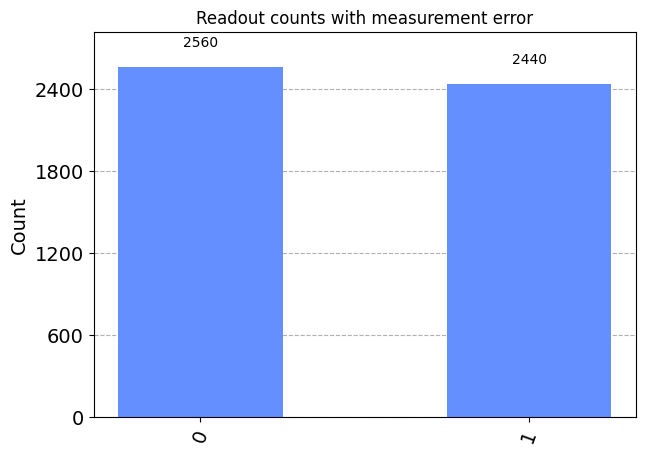

In [19]:
counts = res.get_counts()
fig7 = plot_histogram(counts, title="Readout counts with measurement error")
plt.show()


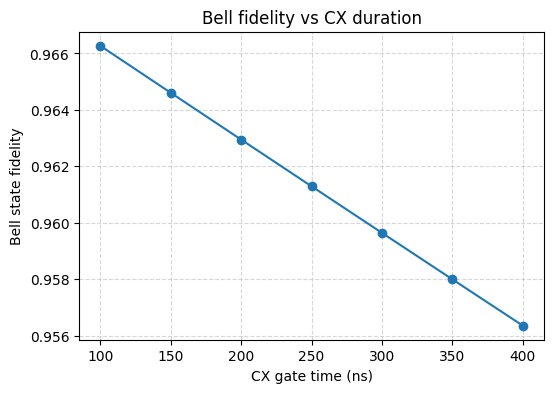

In [20]:
def bell_fidelity_vs_cx_time(cx_times, p2=0.02, T1=50e-6, T2=40e-6, p1=0.01, gate_time_1q=35e-9):
    fids = []
    # Build 1q combined noise once
    depol_1q = depolarizing_error(p1, 1)
    therm_1q = thermal_relaxation_error(T1, T2, gate_time_1q)
    combined_1q = therm_1q.compose(depol_1q)

    # Reference Bell (noiseless)
    bell = QuantumCircuit(2)
    bell.h(0); bell.cx(0,1)
    dm_clean = DensityMatrix(run_and_get_dm(bell, sim_dm_clean))

    for tau2q in cx_times:
        nm = NoiseModel()
        nm.add_all_qubit_quantum_error(combined_1q, ["id","rz","sx","x"])

        depol_2q = depolarizing_error(p2, 2)
        therm_2q = thermal_relaxation_error(T1, T2, tau2q).tensor(
            thermal_relaxation_error(T1, T2, tau2q)
        )
        combined_2q = therm_2q.compose(depol_2q)
        nm.add_all_qubit_quantum_error(combined_2q, ["cx"])

        sim_tmp = AerSimulator(method="density_matrix", noise_model=nm)
        dm_noisy = DensityMatrix(run_and_get_dm(bell, sim_tmp))
        fids.append(state_fidelity(dm_clean, dm_noisy))
    return np.array(fids)

# Sweep a range of CX times (in seconds)
cx_times = np.linspace(100e-9, 400e-9, 7)  # 100 ns → 400 ns
fids = bell_fidelity_vs_cx_time(cx_times)

plt.figure(figsize=(6,4))
plt.plot(cx_times*1e9, fids, marker="o")
plt.xlabel("CX gate time (ns)")
plt.ylabel("Bell state fidelity")
plt.title("Bell fidelity vs CX duration")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
